In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!cp /content/drive/'My Drive'/'Colab Notebooks'/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [47]:
import numpy as np 
from sklearn.model_selection import train_test_split 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')
frames = [mainData, extraData]
isCancerousData = pd.concat(frames)

In [48]:
#drop IDs
isCancerousData.drop(['InstanceID', 'patientID', 'cellType'], axis = 1, inplace =True)
isCancerousData['ImgPath'] = './patch_images/' + isCancerousData['ImageName']

In [49]:
isCancerousData.head()

,ImageName,cellTypeName,isCancerous,ImgPath
0,22405.png,fibroblast,0,./patch_images/22405.png
1,22406.png,fibroblast,0,./patch_images/22406.png
2,22407.png,fibroblast,0,./patch_images/22407.png
3,22408.png,fibroblast,0,./patch_images/22408.png
4,22409.png,fibroblast,0,./patch_images/22409.png


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


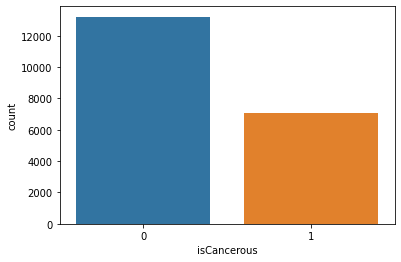

In [50]:
sns.countplot(isCancerousData['isCancerous'])

In [51]:
CLASSES = 2

train_data, test_data = train_test_split(isCancerousData, test_size=0.2, random_state=42) 

train_data, val_data = train_test_split(isCancerousData, test_size=0.25, random_state=42) 

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0])) 

target = train_data['isCancerous']

Train data : 15210, Val Data: 5070, Test Data: 4056


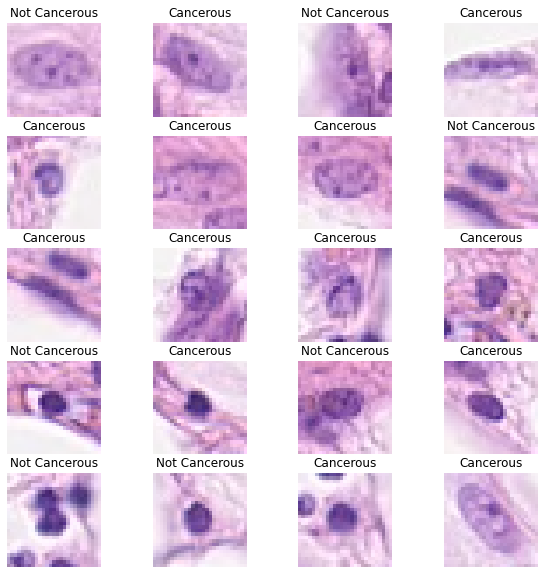

In [52]:
from PIL import Image

label_names = {'Cancerous':0, 'Not Cancerous':1}
d_inv = {v: k for k, v in label_names.items()}

img_list = list(isCancerousData['ImgPath'])
target_list = list(target)

fig = plt.figure(figsize = [10, 10])
fig.tight_layout()
for i in np.arange(20):
    plt.subplot(5, 4, i + 1)
    img = Image.open(img_list[i])

    plt.imshow(img)
    plt.title(d_inv[target_list[i]])
    plt.axis('off')

In [53]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

In [54]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Found 15210 validated image filenames belonging to 2 classes.
Found 5070 validated image filenames belonging to 2 classes.


In [55]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [56]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(27,27,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same"),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu', input_shape=(27,27,3,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [62]:
# (4) Compile 
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

# (5) Train
history = model.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

KeyboardInterrupt: ignored